# EDA

In [3]:

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
import requests
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval
import statsmodels.api as sm
from wordcloud import WordCloud, STOPWORDS



In [1]:
# Check none value
def checkNone(givenlist, value):
    """
    This function Check none value in a list.
    
    arguments: list
    returns: Boolean index
    
    """
    return all([element == value for element in givenlist])


# Create profit
def prof(df, rev, bug, out):
    """
    This function Create profit to a dataframe.
    
    arguments: dataframe and corresponding variables
    returns: profit column
    
    """
    for i in range(df.shape[0]):
        if df[bug][i] == 0 or df[rev][i] == 0:
            df[out][i] = 0
        else:
            df[out][i] = df[rev][i] - df[bug][i]

    return df[out]


# Create roi
def roi(df, rev, bug, out):
    """
    This function Create ROI to a dataframe.
    
    arguments: dataframe and corresponding variables
    returns: ROI column
    
    """
    for i in range(df.shape[0]):
        if df[bug][i] == 0 or df[rev][i] == 0:
            df[out][i] = 0
        else:
            df[out][i] = (df[rev][i] - df[bug][i]) / df[bug][i]

    return df[out]

## Data Extraction

In [5]:
movies_meta = pd.read_csv('movies_metadata.csv')

In [6]:
movies_meta.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


### Data Cleaning

In [7]:
# Drop not usefull variables and dirty rows, assign a new dataframe to make word cloud
movies_meta = movies_meta[movies_meta['adult'].isin(['False','True'])]
movies_meta.drop(['belongs_to_collection', 'production_companies','spoken_languages','poster_path','homepage'], axis=1, inplace=True)
movies_meta.reset_index(drop=True, inplace=True)
movies_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45463 entries, 0 to 45462
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   adult                 45463 non-null  object 
 1   budget                45463 non-null  object 
 2   genres                45463 non-null  object 
 3   id                    45463 non-null  object 
 4   imdb_id               45446 non-null  object 
 5   original_language     45452 non-null  object 
 6   original_title        45463 non-null  object 
 7   overview              44509 non-null  object 
 8   popularity            45460 non-null  object 
 9   production_countries  45460 non-null  object 
 10  release_date          45376 non-null  object 
 11  revenue               45460 non-null  float64
 12  runtime               45203 non-null  float64
 13  status                45379 non-null  object 
 14  tagline               20412 non-null  object 
 15  title              

In [8]:
# drop duplicated rows
dup_data = movies_meta.duplicated(keep = False)
movies_meta = movies_meta[~dup_data]

In [9]:
# Fill NA with mean or unknown
movies_meta['runtime'] = movies_meta['runtime'].fillna(value = pd.Series(movies_meta['runtime']).mean())
movies_meta['release_date'] = movies_meta['release_date'].fillna(value = pd.to_datetime(movies_meta['release_date']).mean())
movies_meta['status'] = movies_meta['status'].fillna("unknown")
movies_meta['original_language'] = movies_meta['original_language'].fillna(value = "en")
movies_meta['tagline'] = movies_meta['tagline'].fillna(value = " ")
movies_meta['overview'] = movies_meta['overview'].fillna(value = " ")
movies_meta['imdb_id'] = movies_meta['imdb_id'].fillna(value = " ")
movies_meta.isnull().sum()

adult                   0
budget                  0
genres                  0
id                      0
imdb_id                 0
original_language       0
original_title          0
overview                0
popularity              3
production_countries    3
release_date            0
revenue                 3
runtime                 0
status                  0
tagline                 0
title                   3
video                   3
vote_average            3
vote_count              3
dtype: int64

In [10]:
# remove the rows with NA value
movies_meta.dropna(axis = 0, how ='any', inplace = True)
movies_meta.reset_index(drop = True, inplace = True)
movies_meta.isnull().sum()

adult                   0
budget                  0
genres                  0
id                      0
imdb_id                 0
original_language       0
original_title          0
overview                0
popularity              0
production_countries    0
release_date            0
revenue                 0
runtime                 0
status                  0
tagline                 0
title                   0
video                   0
vote_average            0
vote_count              0
dtype: int64

In [11]:
# turn to float type
floatvar = ('budget','popularity','revenue','runtime','vote_average','vote_count')
for i in floatvar:
    movies_meta[i] = movies_meta[i].astype(float)

In [12]:
# create profit and roi
movies_meta['profit'] = 0
movies_meta['profit'] = prof(movies_meta,rev='revenue',bug='budget',out='profit')
movies_meta['roi'] = 1.0
movies_meta['roi'] = roi(movies_meta,rev='revenue',bug='budget',out='roi')

In [13]:
movies_meta[movies_meta['profit'] == 0].count()

adult                   40074
budget                  40074
genres                  40074
id                      40074
imdb_id                 40074
original_language       40074
original_title          40074
overview                40074
popularity              40074
production_countries    40074
release_date            40074
revenue                 40074
runtime                 40074
status                  40074
tagline                 40074
title                   40074
video                   40074
vote_average            40074
vote_count              40074
profit                  40074
roi                     40074
dtype: int64

In [14]:
# create gain feature
movies_meta['gain'] = False
for i in range(movies_meta.shape[0]):
    if movies_meta['profit'][i] > 0:
        movies_meta['gain'][i] = True
    elif movies_meta['profit'][i] < 0:
        movies_meta['gain'][i] = False
    else: movies_meta['gain'][i] = 'unknown'



In [15]:
# Extract movie gneres from dictionary of column genres
movies_meta['genres_clean'] = movies_meta['genres'].fillna('[]').apply(literal_eval)
movies_meta['genres_clean'] = movies_meta['genres_clean'].apply(lambda x: [i['name'] for i in x])
movies_meta['genres_clean'].head()

0     [Animation, Comedy, Family]
1    [Adventure, Fantasy, Family]
2               [Romance, Comedy]
3        [Comedy, Drama, Romance]
4                        [Comedy]
Name: genres_clean, dtype: object

In [16]:
# Extract movie countries from dictionary of column production_countries
movies_meta['country'] = movies_meta['production_countries'].fillna('[]').apply(literal_eval)
movies_meta['country'] = movies_meta['country'].apply(lambda x: [i['iso_3166_1'] for i in x] if isinstance(x, list) else None)
movies_meta['country'].tail()

45430    [IR]
45431    [PH]
45432    [US]
45433    [RU]
45434    [GB]
Name: country, dtype: object

In [17]:
movies_meta.reset_index(drop = True, inplace = True)
movies_meta_story = movies_meta[['title','overview','tagline']]

In [18]:
# select the first one country from list of country 
# it will takes 20 seconds, please wait

for i in range(len(movies_meta['country'])-1):
    if isinstance(movies_meta['country'][i],list):
        if checkNone(movies_meta['country'][i],None):
            movies_meta['production_countries'][i] = 'unknown'
        else: movies_meta['production_countries'][i] = movies_meta['country'][i][0]
    else: movies_meta['production_countries'][i] = 'unknown'
movies_meta['production_countries']


0                                                      US
1                                                      US
2                                                      US
3                                                      US
4                                                      US
                               ...                       
45430                                                  IR
45431                                                  PH
45432                                                  US
45433                                                  RU
45434    [{'iso_3166_1': 'GB', 'name': 'United Kingdom'}]
Name: production_countries, Length: 45435, dtype: object

In [19]:
# movies_meta will be stacked by genres, movies_meta_unstack is the dataframe before stacking
movies_meta_unstack = movies_meta

In [20]:
# create stack of genres
# it will takes 20 seconds, please wait
movies_meta.drop(['genres'], axis=1, inplace=True)
g = (movies_meta['genres_clean'].apply(lambda x: pd.Series(list(x)))
                  .stack()
                  .rename('genres')
                  .reset_index(level=1, drop=True))
movies_meta = movies_meta.join(g).reset_index(drop=True)



In [21]:
# drop unuseful variables
movies_meta.drop(['genres_clean','country','overview','tagline'], axis=1, inplace=True)
movies_meta.rename(columns={'production_countries': 'country'},inplace=True, errors='raise')

In [22]:
# Data cleaning process, all set! 
# please review in excel
# movies_meta.to_csv('test.csv',header=True)

In [23]:
movies_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93465 entries, 0 to 93464
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   adult              93465 non-null  object 
 1   budget             93465 non-null  float64
 2   id                 93465 non-null  object 
 3   imdb_id            93465 non-null  object 
 4   original_language  93465 non-null  object 
 5   original_title     93465 non-null  object 
 6   popularity         93465 non-null  float64
 7   country            93465 non-null  object 
 8   release_date       93465 non-null  object 
 9   revenue            93465 non-null  float64
 10  runtime            93465 non-null  float64
 11  status             93465 non-null  object 
 12  title              93465 non-null  object 
 13  video              93465 non-null  object 
 14  vote_average       93465 non-null  float64
 15  vote_count         93465 non-null  float64
 16  profit             934

## Let's begin the EDA

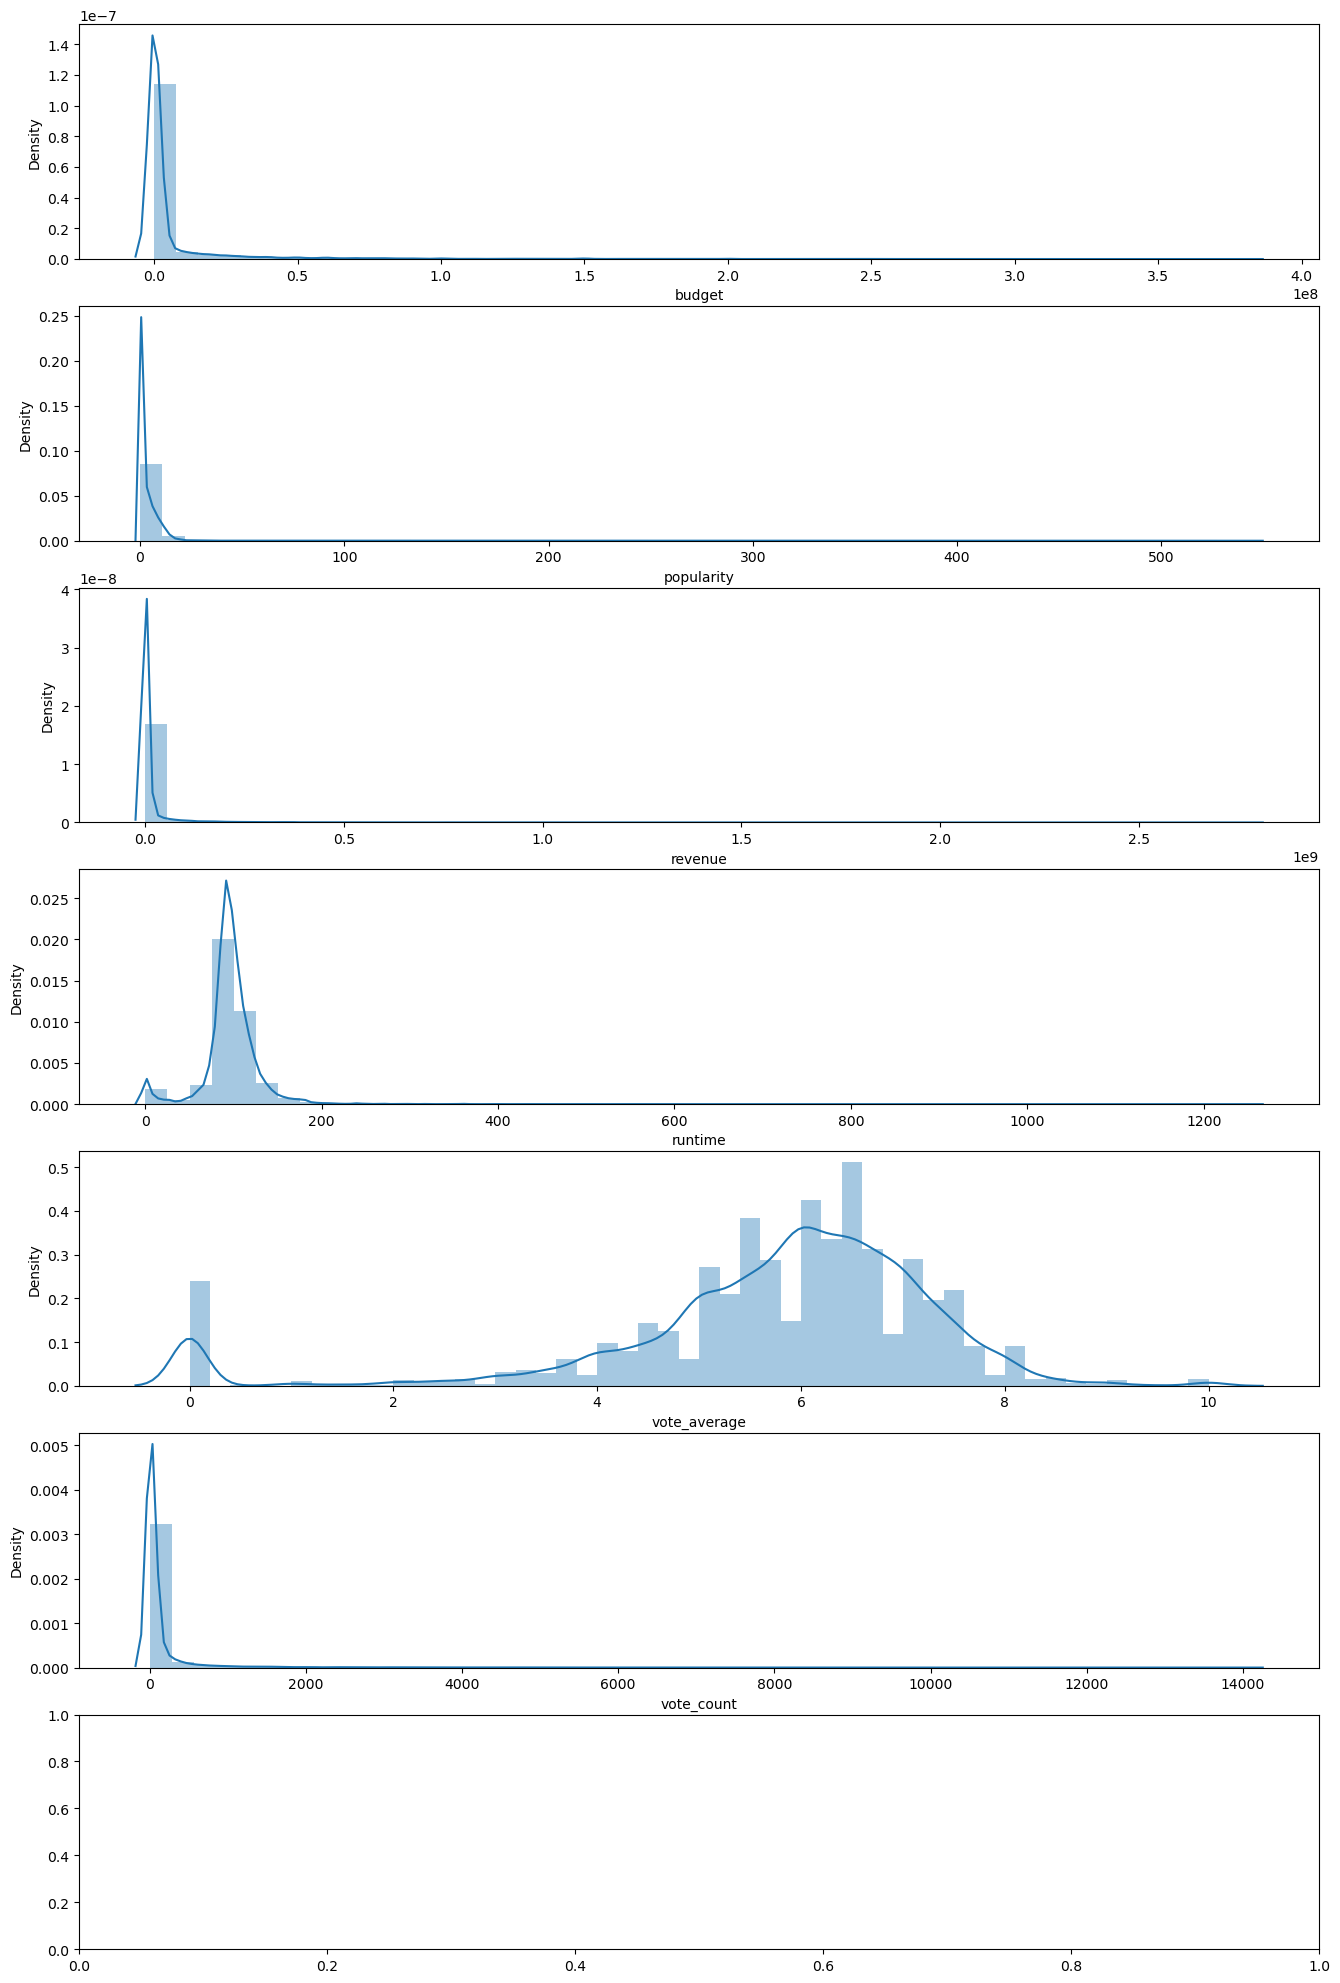

In [27]:
# Density plot of numerical data
fig, axes = plt.subplots(7, 1, figsize=(16, 25))
for i, d in zip(range(7), floatvar):
    sns.distplot(movies_meta[d], ax = axes[i])


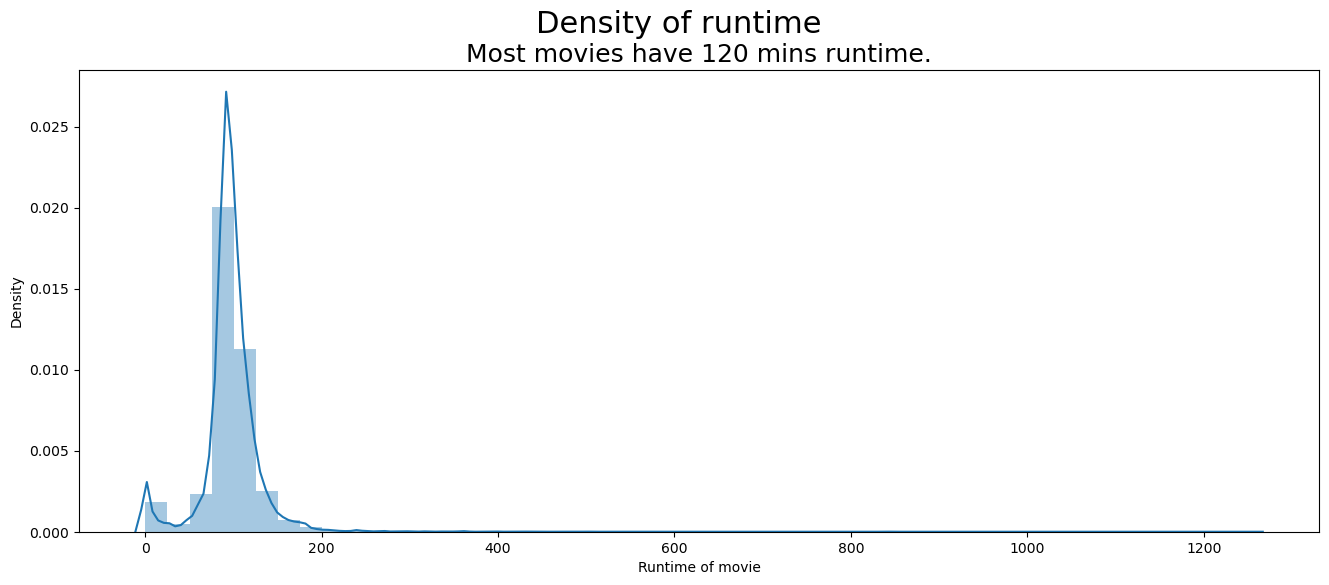

In [28]:
fig, ax = plt.subplots(figsize=(16, 6))
sns.distplot(movies_meta['runtime'])
plt.xlabel('Runtime of movie') 

plt.title("Most movies have 120 mins runtime.", fontsize = 18)
plt.suptitle('Density of runtime', fontsize = 22)
plt.show()

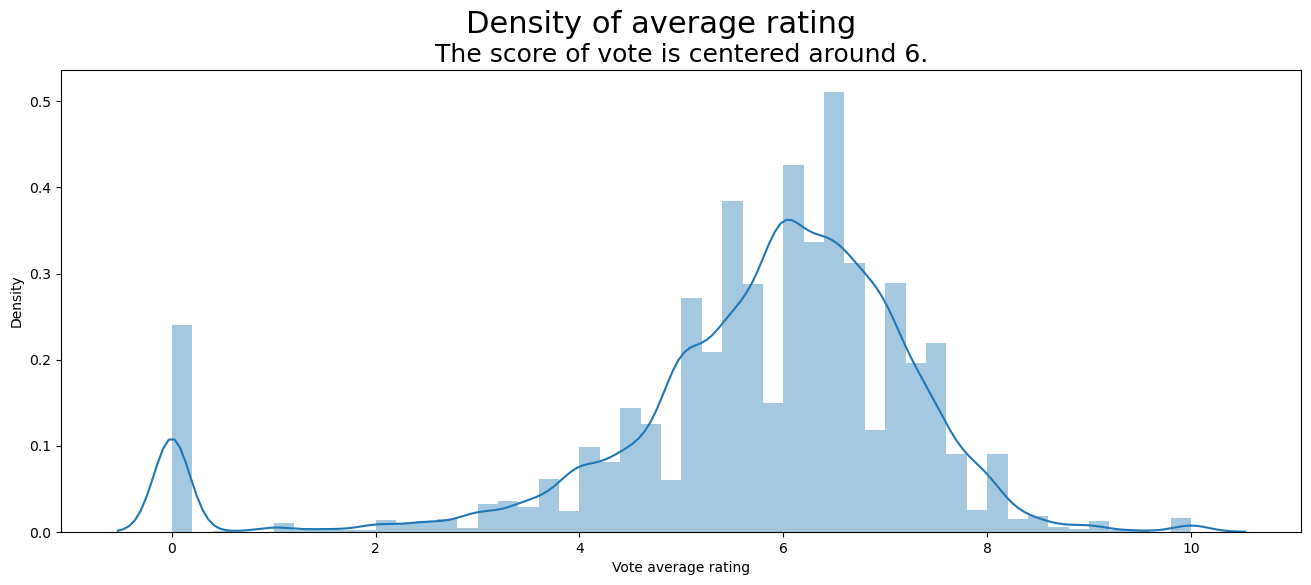

In [29]:
fig, ax = plt.subplots(figsize=(16, 6))
sns.distplot(movies_meta['vote_average'])
plt.xlabel('Vote average rating') 

plt.title("The score of vote is centered around 6.", fontsize = 18)
plt.suptitle('Density of average rating', fontsize = 22)
plt.show()

(0.0, 20000000.0)

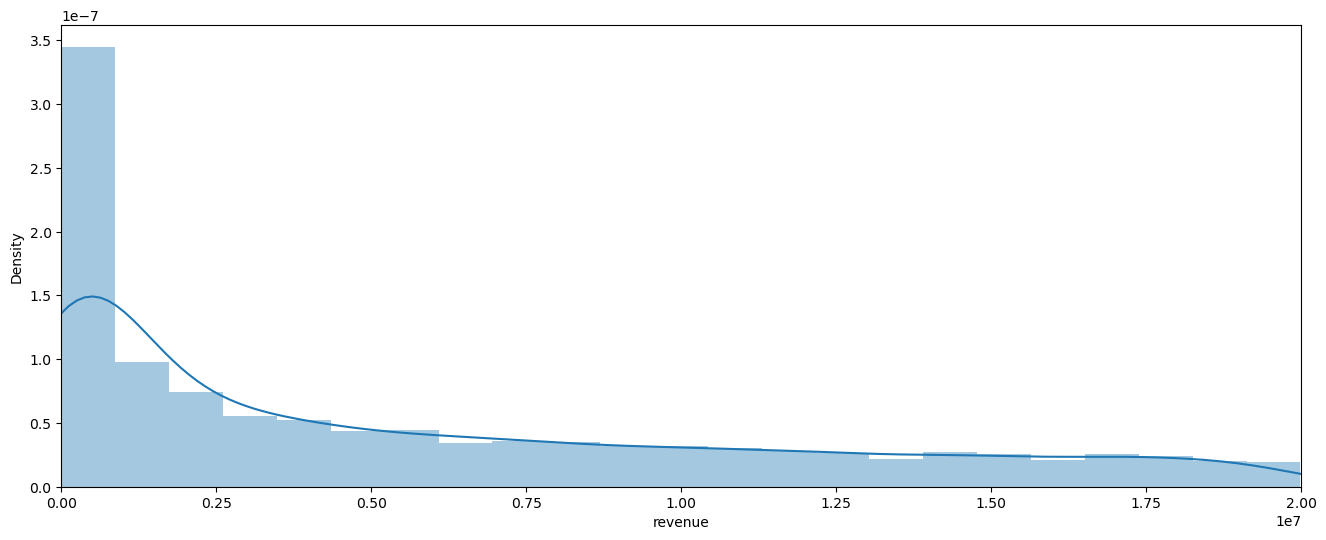

In [30]:
revenue_data = movies_meta[movies_meta['revenue'] < 20000000 ]
revenue_data = revenue_data[revenue_data['revenue'] != 0]
fig, ax = plt.subplots(figsize=(16, 6))
sns.distplot(revenue_data['revenue'])
plt.xlim(0,20000000)

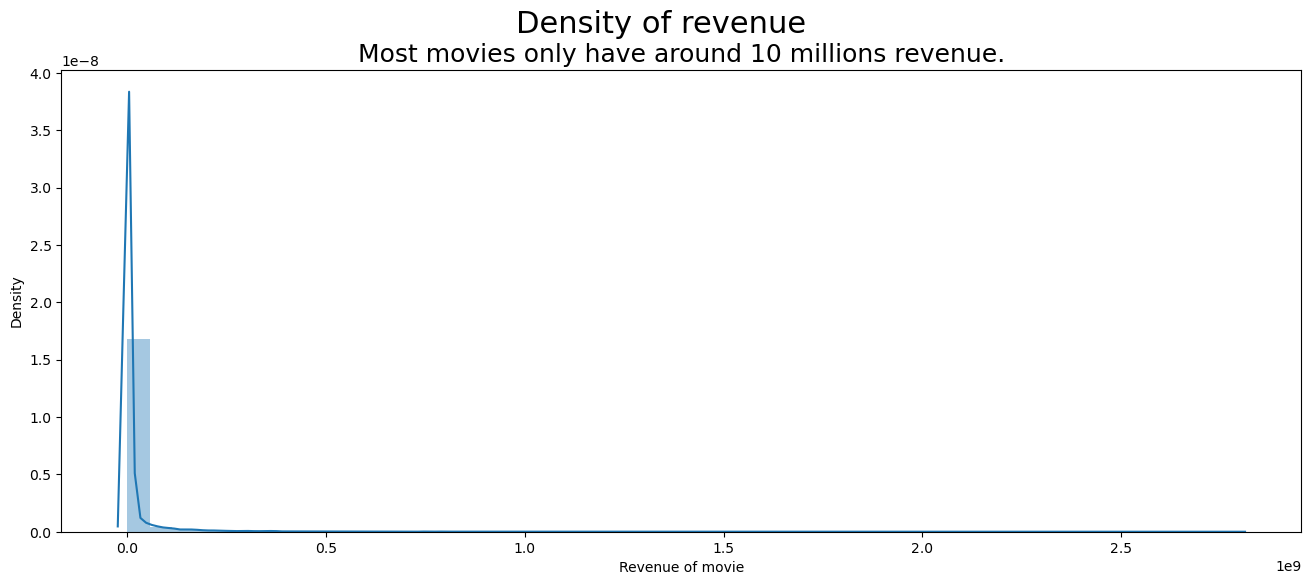

In [31]:
fig, ax = plt.subplots(figsize=(16, 6))
sns.distplot(movies_meta['revenue'])
plt.xlabel('Revenue of movie') 

plt.title("Most movies only have around 10 millions revenue.", fontsize = 18)
plt.suptitle('Density of revenue', fontsize = 22)
plt.show()

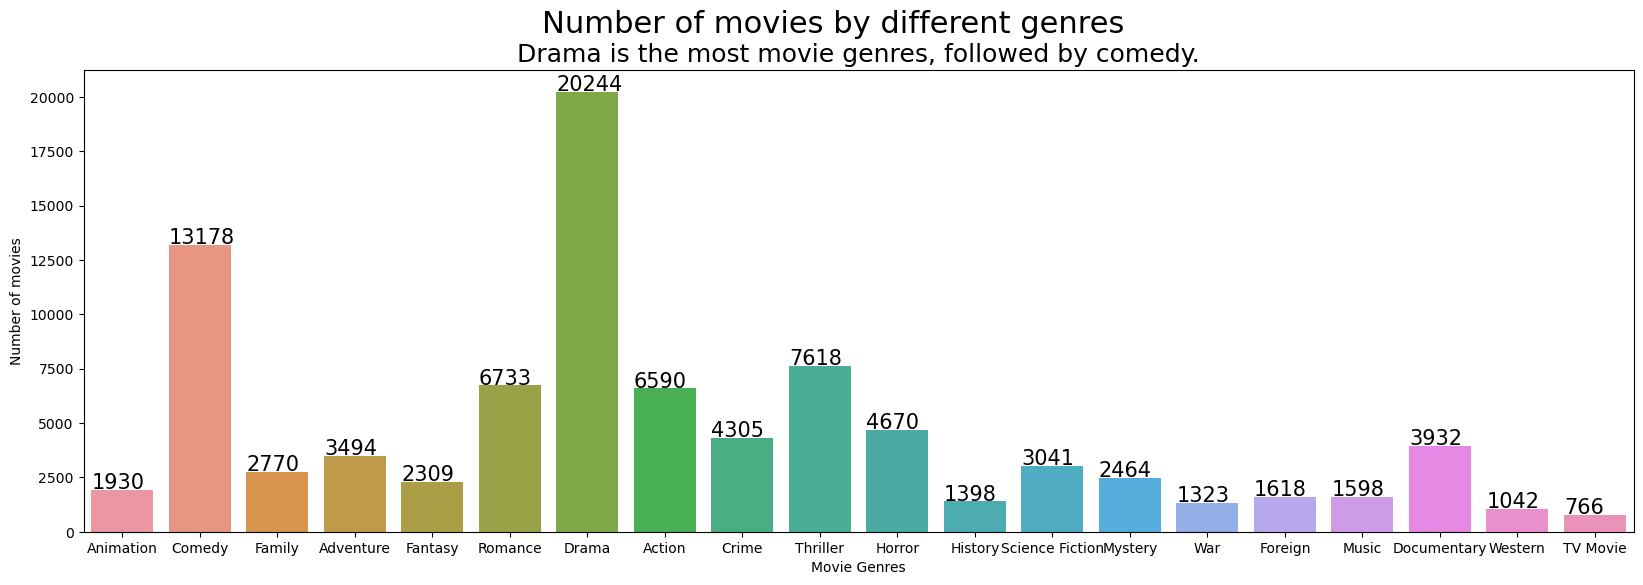

In [32]:
# One movie may have mutiple genres, so the sum of movies in this plot is not the same as the total numbers of movies.
fig, ax = plt.subplots(figsize=(20, 6))
sns.countplot(data= movies_meta,x= 'genres' , ax =ax)
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x(), p.get_height()+50), color='black', size=15)

plt.xlabel('Movie Genres') 
plt.ylabel('Number of movies') 
plt.title("Drama is the most movie genres, followed by comedy.", fontsize = 18)
plt.suptitle('Number of movies by different genres', fontsize = 22)
plt.show()

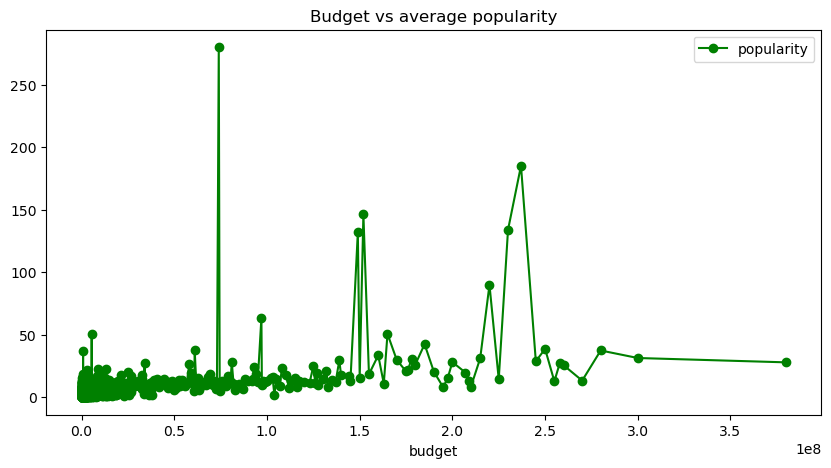

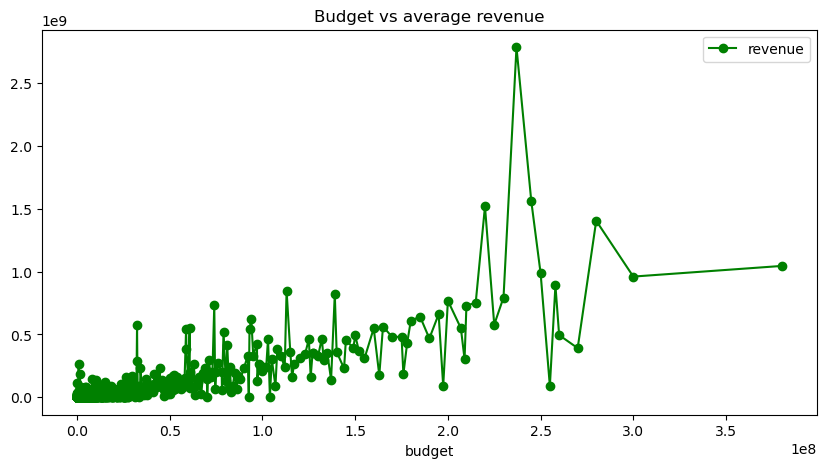

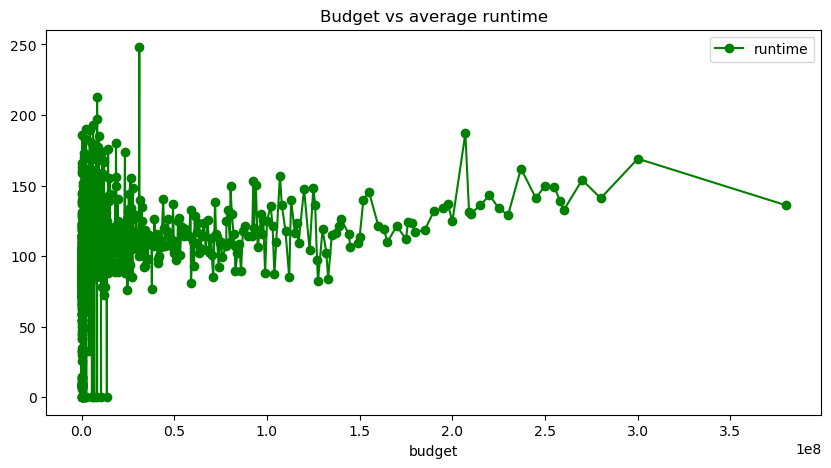

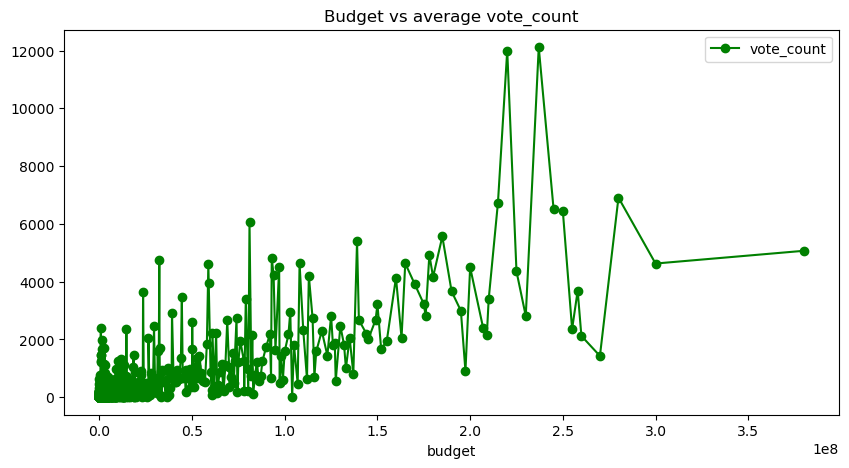

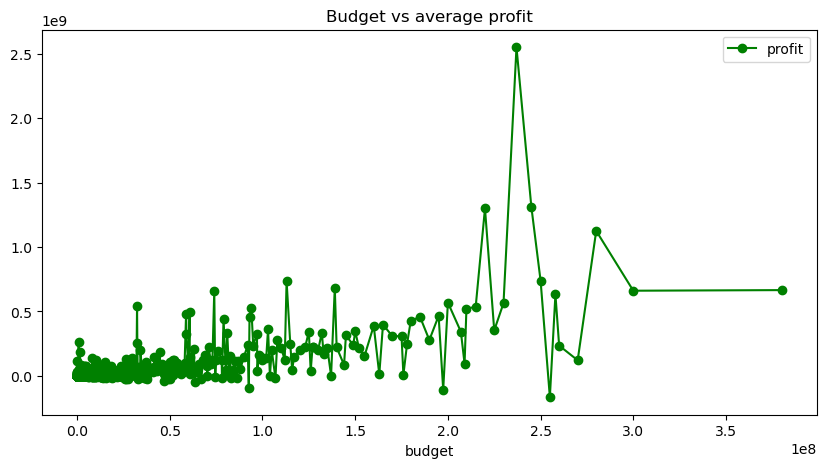

In [33]:
# scatter plot for average budget
for i in ('popularity','revenue','runtime','vote_count','profit'):
    axis = movies_meta.groupby('budget')[[i]].mean().plot(figsize=(10,5),marker='o',color='g')
    plt.title(f"Budget vs average {i}")

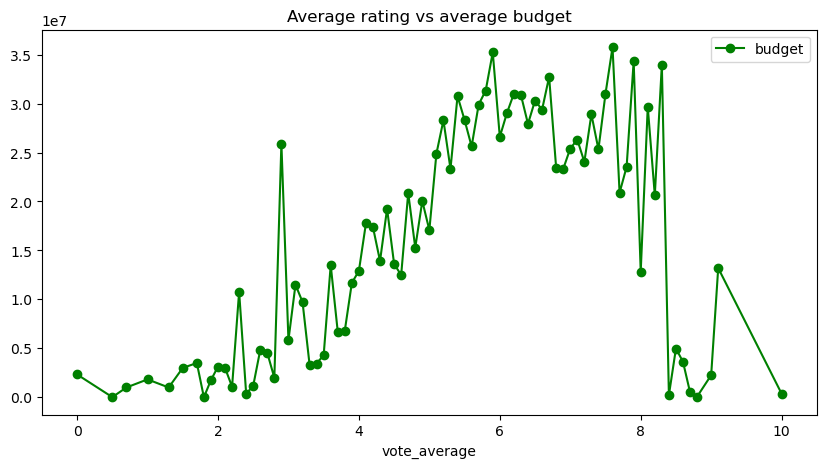

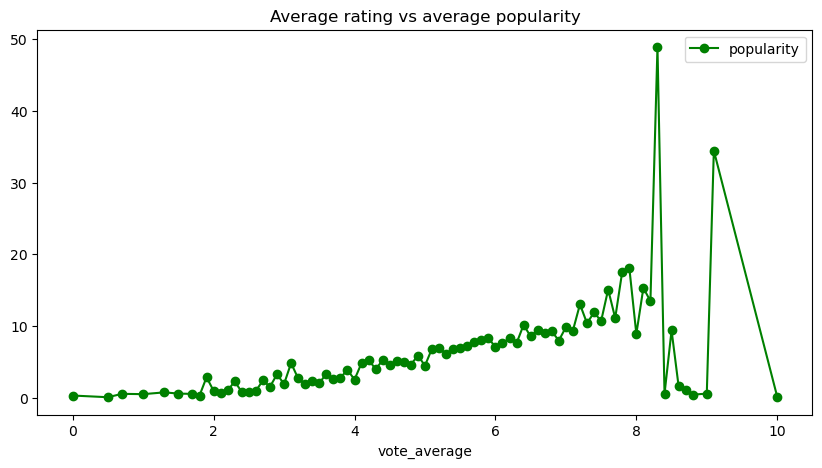

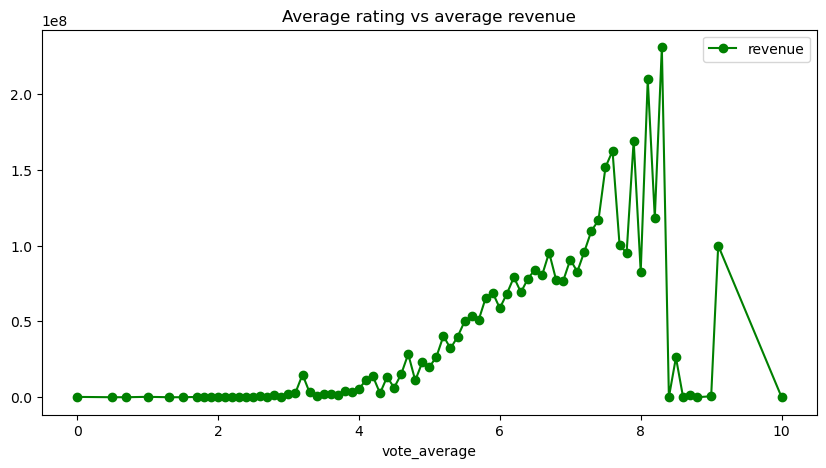

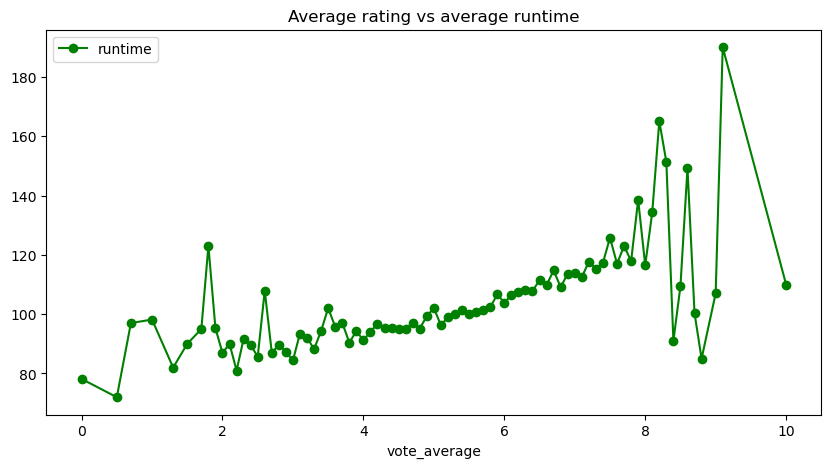

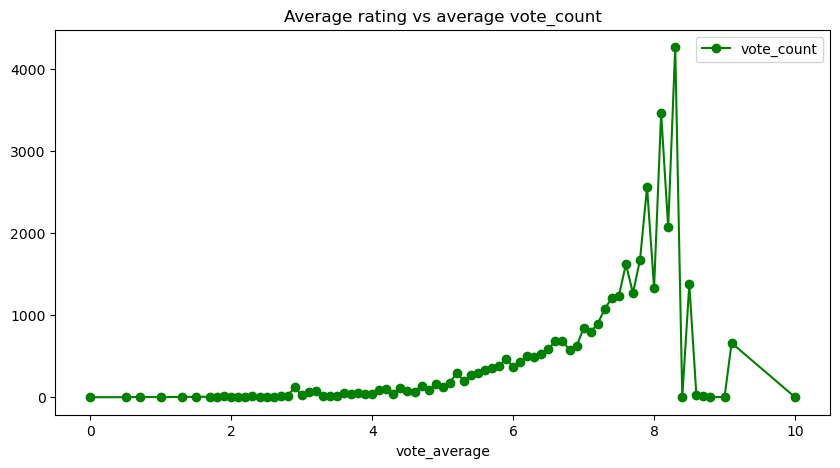

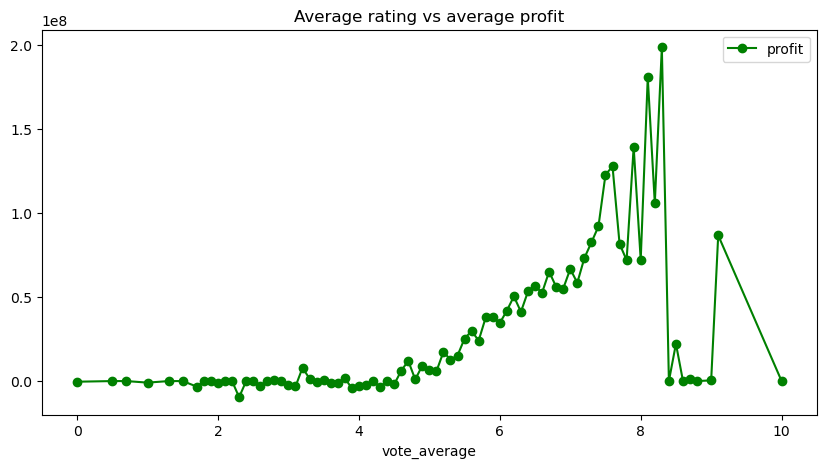

In [34]:
# scatter plot for average rating
plotdata = movies_meta[movies_meta['budget'] > 1000]
for i in ('budget','popularity','revenue','runtime','vote_count','profit'):
    axis = plotdata.groupby('vote_average')[[i]].mean().plot(figsize=(10,5),marker='o',color='g')
    plt.title(f"Average rating vs average {i}")

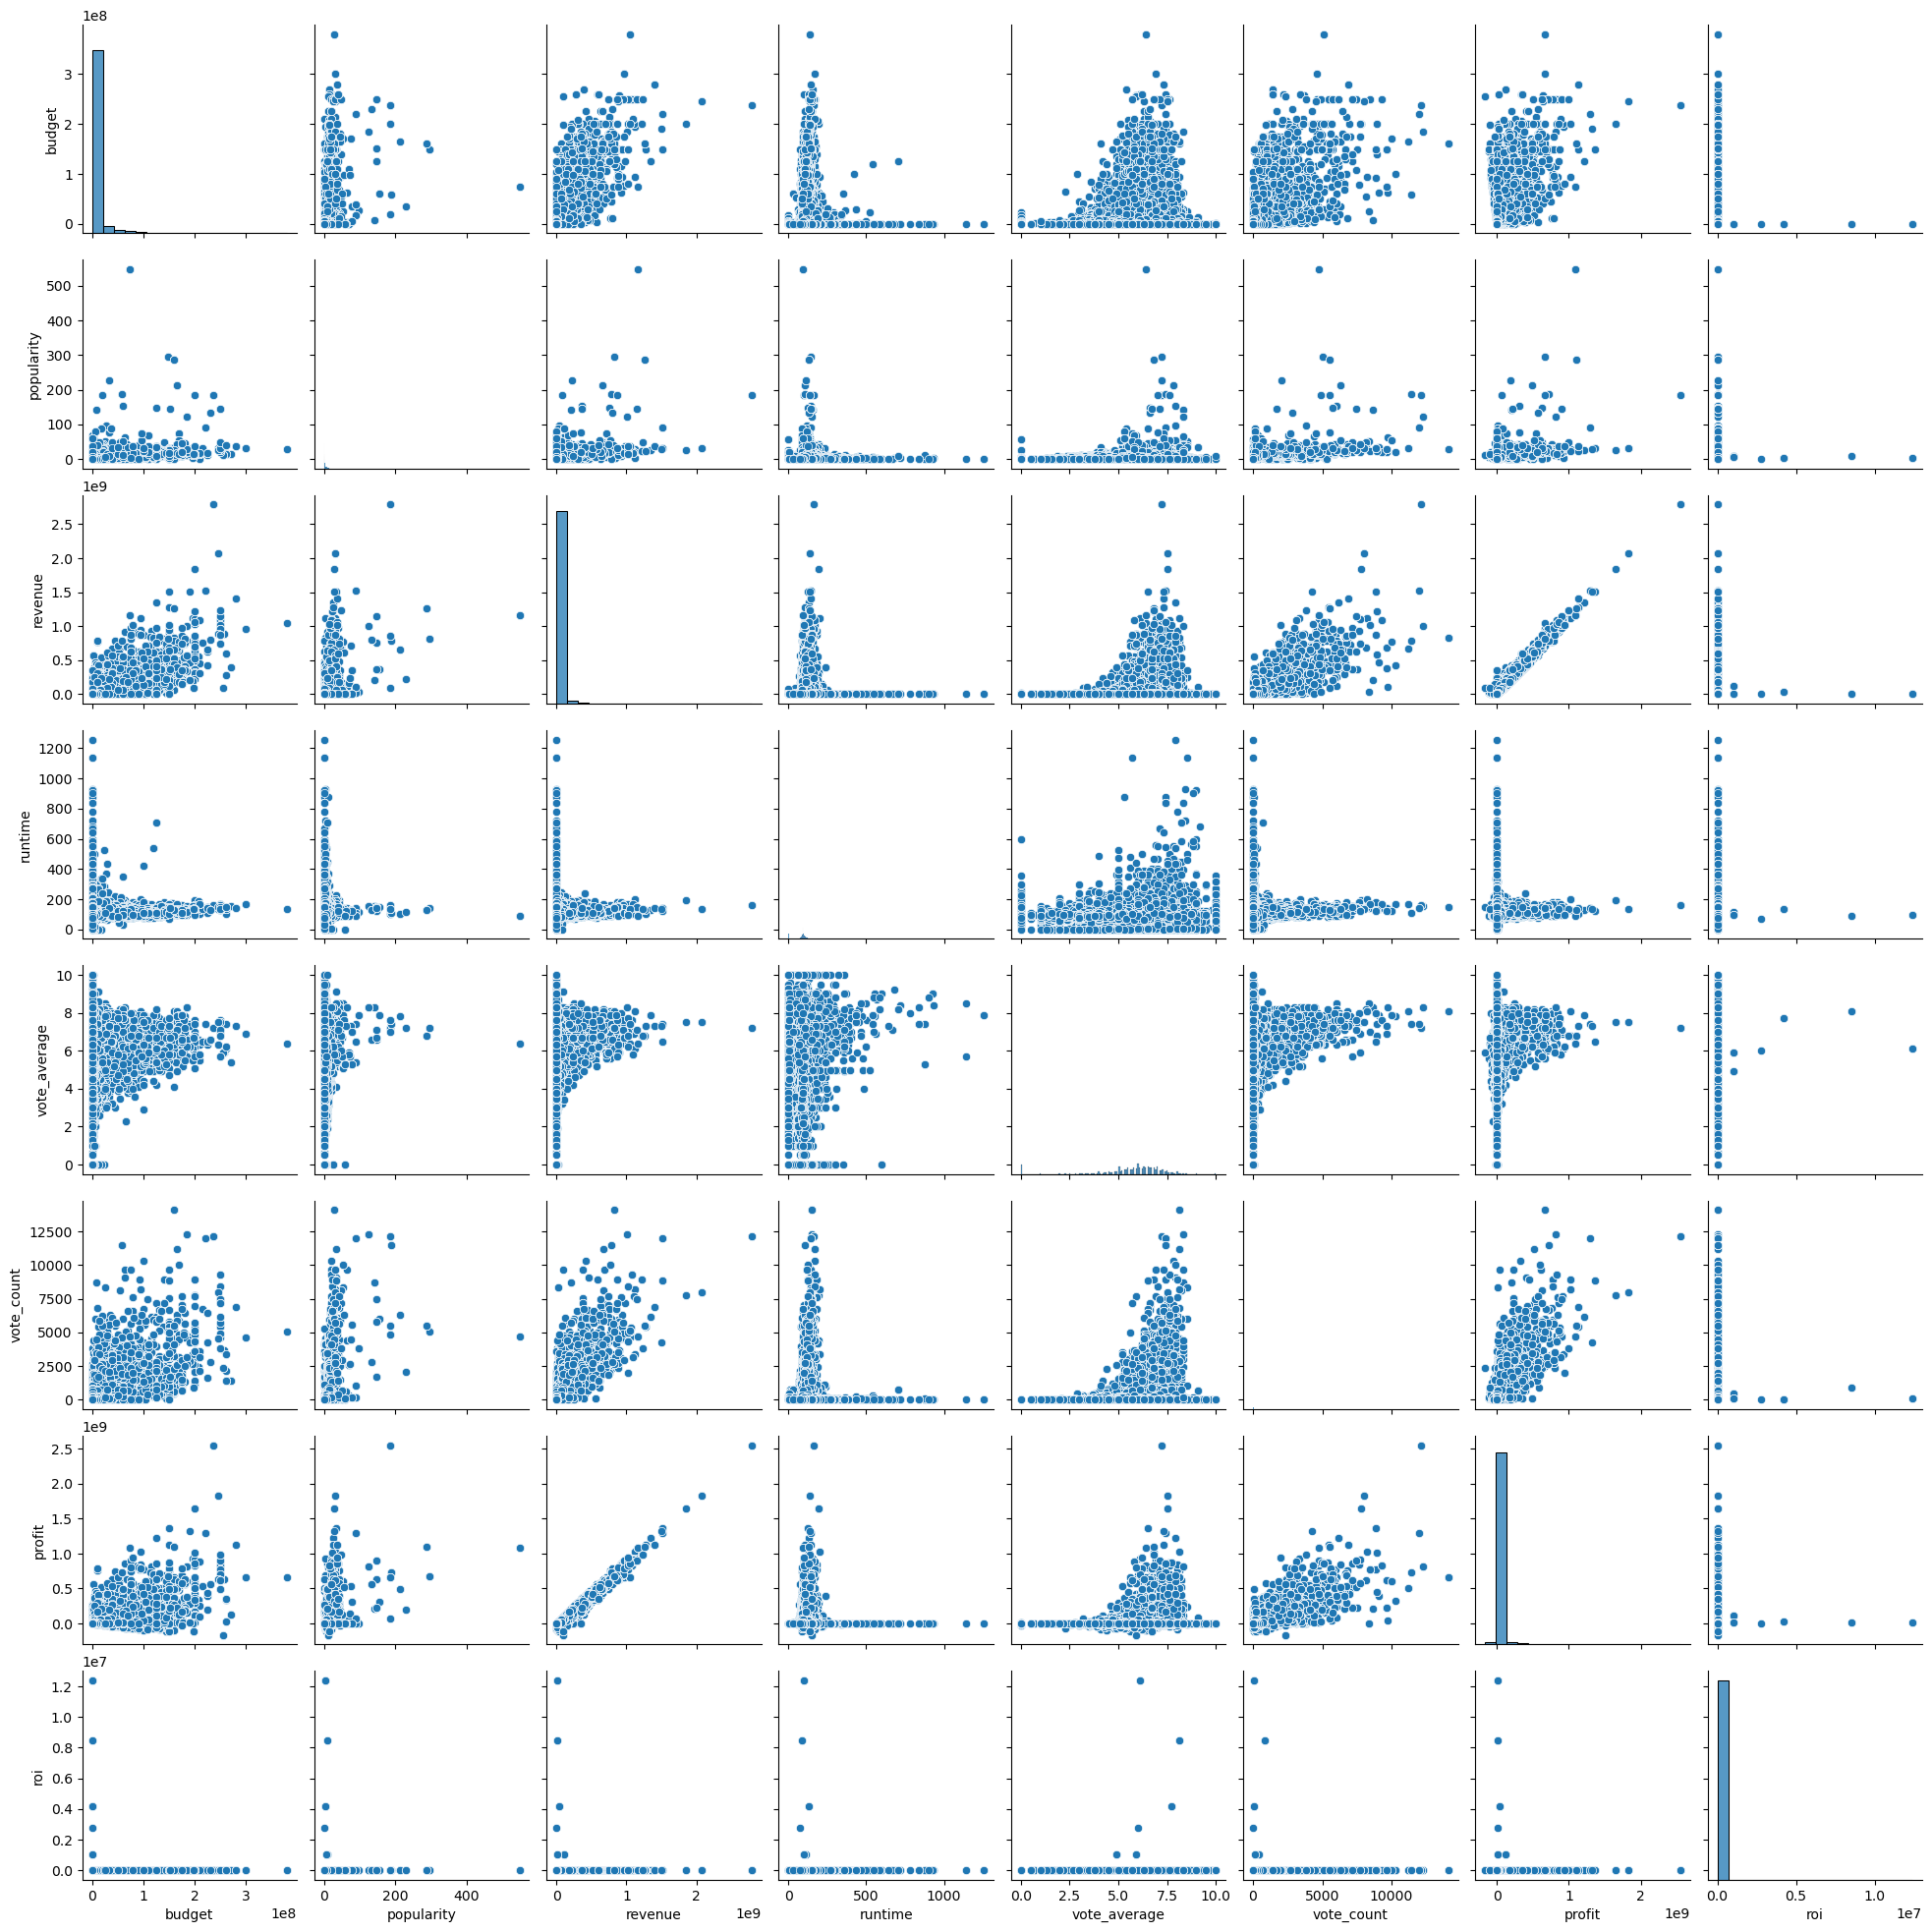

In [35]:
# pairplot
pairplotdata = movies_meta[['budget','popularity','revenue','runtime','vote_average','vote_count','profit','roi']]
sns.pairplot(data=pairplotdata)
plt.show()

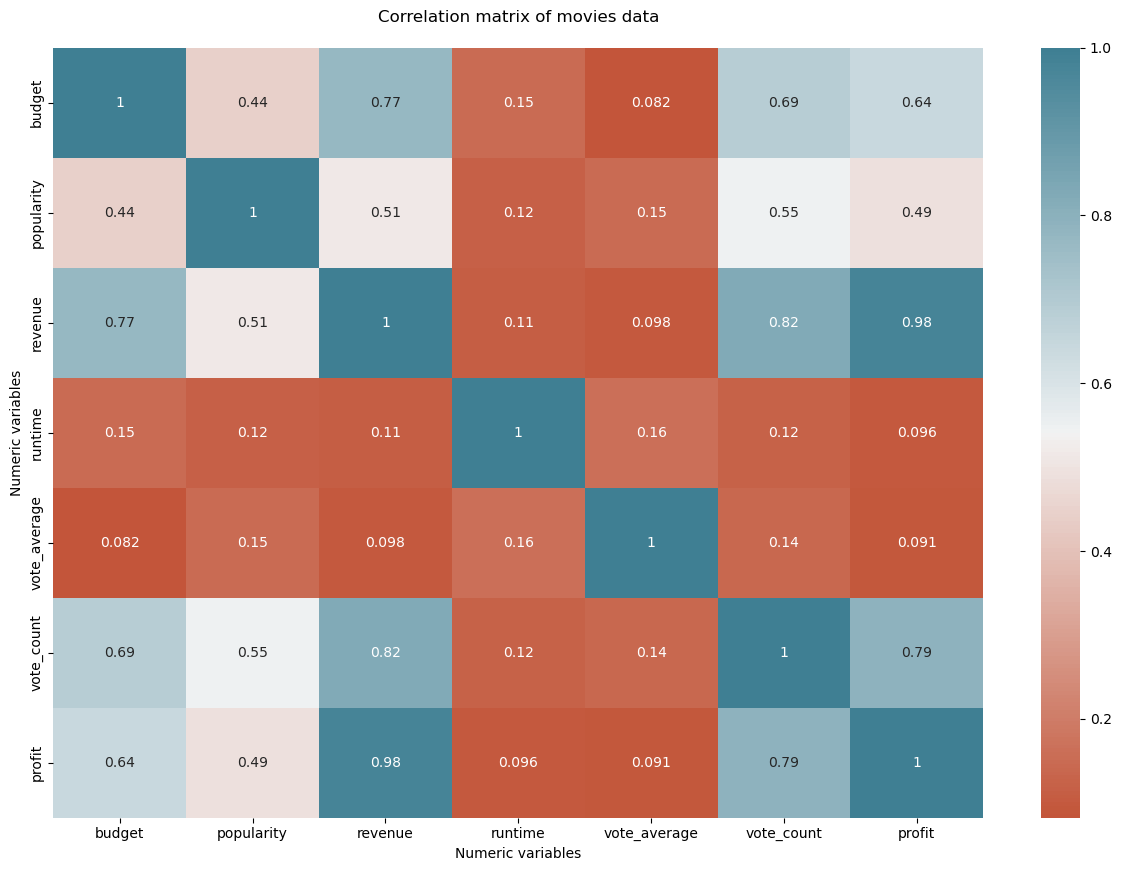

In [36]:
# correlation matrix
fig, ax = plt.subplots(figsize=(15, 10))
corrplot = sns.heatmap(movies_meta[['budget','popularity','revenue','runtime','vote_average','vote_count','profit']].corr(),
cmap=sns.diverging_palette(20, 220, n=200), annot = True)

corrplot.set(xlabel='Numeric variables', ylabel='Numeric variables', title = "Correlation matrix of movies data\n")

plt.show()

In [37]:
for i in range(movies_meta_unstack.shape[0]):
    if movies_meta_unstack['budget'][i] == movies_meta_unstack['revenue'][i] and movies_meta_unstack['budget'][i] != 0 and movies_meta_unstack['revenue'][i] != 0:
        print(i)
    

2545
11340
13858
15678
15905
23530
31449
33265
34508
35058
38239
38240
38241
38242
38243
38244
38245
38246
40651
43618


In [39]:
#Which movie genres are more likely to receive high ratings, so we can figure out what sort of movies the audience favored throughout the period covered by the dataset.
import matplotlib.mlab as mlab  
import matplotlib.pyplot as plt 
import statsmodels.formula.api as smf
movies1 = movies_meta[movies_meta['vote_count'] != 0]
df1 = movies1.groupby('genres')['vote_average'].mean().sort_values()
df1 = df1.to_frame()
df1.reset_index(drop = False, inplace = True)
df1

,genres,vote_average
0,Horror,5.311242
1,Science Fiction,5.466375
2,TV Movie,5.641350
3,Western,5.709650
4,Thriller,5.733088
5,Action,5.745418
6,Adventure,5.872273
7,Fantasy,5.919558
8,Family,5.933321
9,Mystery,5.959684


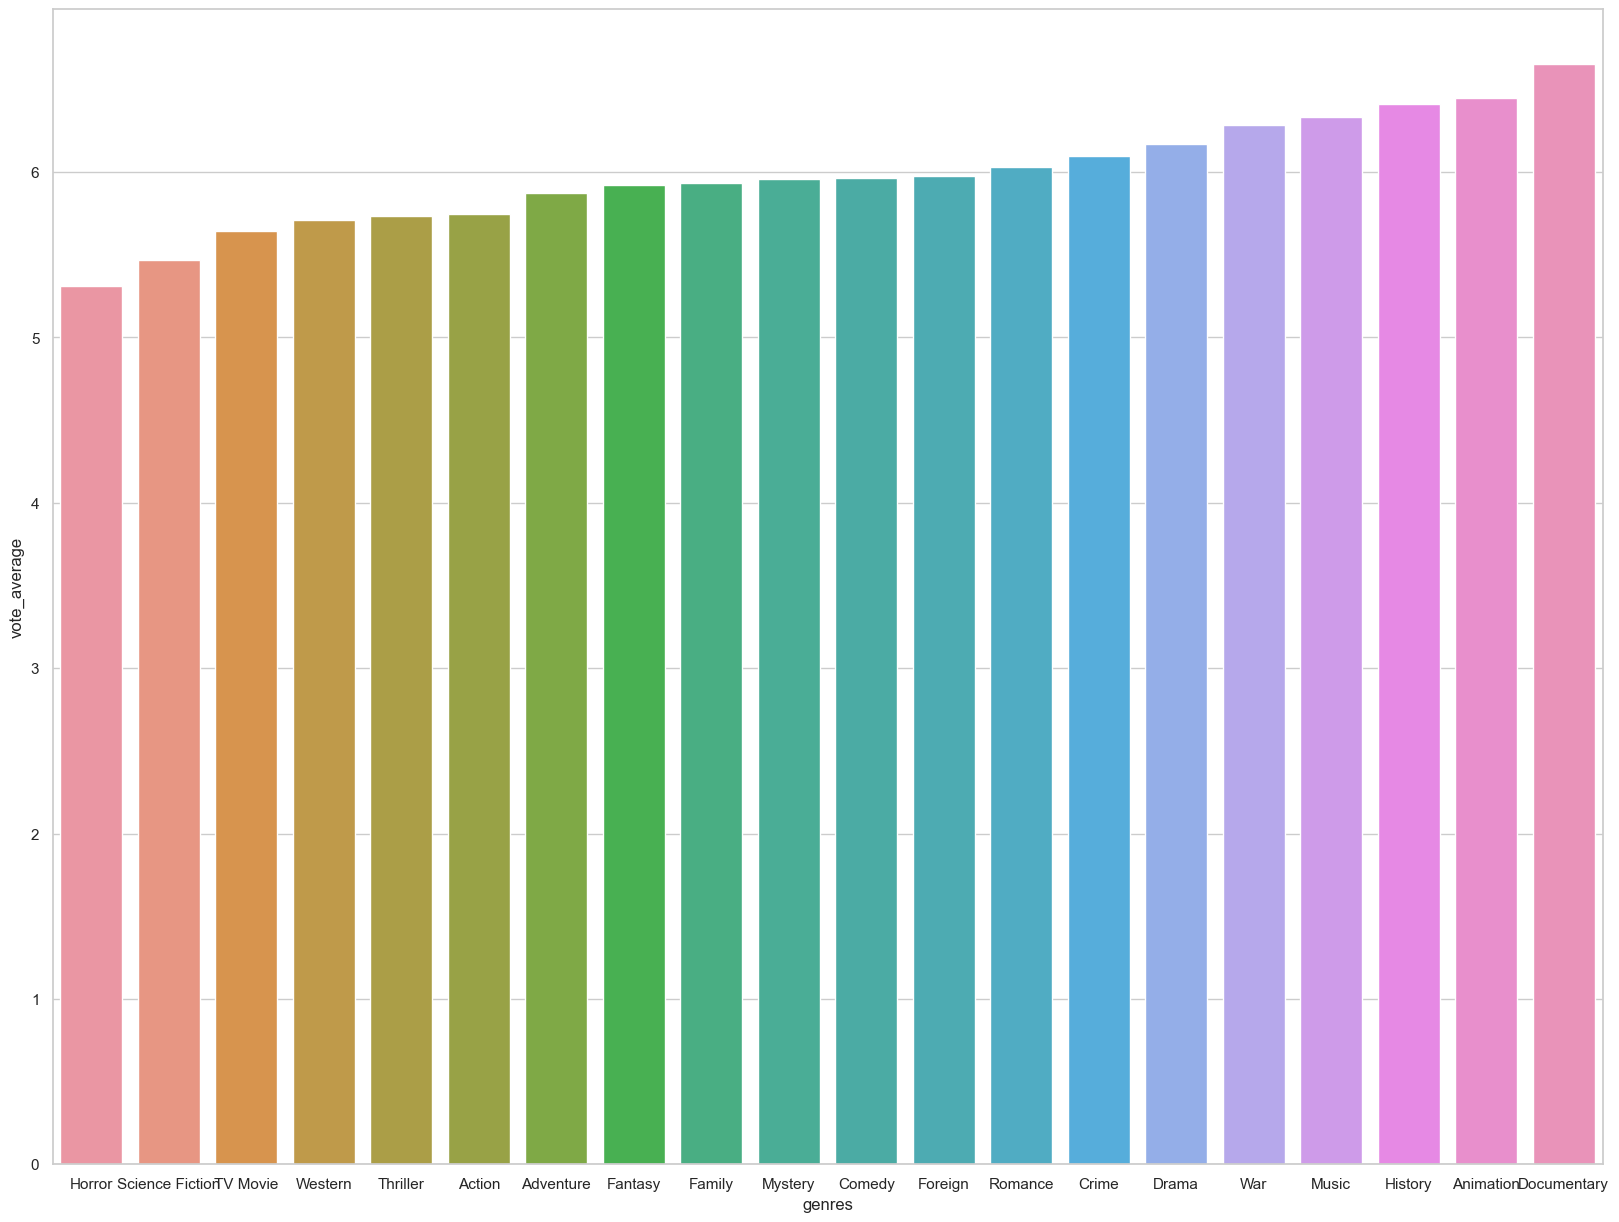

In [40]:
plt.figure(figsize=(20, 15))
sns.set_theme(style="whitegrid")
sns.barplot(x="genres", y="vote_average", data=df1)
plt.show()

### Question 3

In [41]:
#Are there substantial differences between English-language films and those in other languages in certain variables? Can we determine a film's linguistic kind based on these differences?sssssssaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaAAssssssssssssssssssssssssssssssssssssssssssssssssssssssxxxzz                 ddddddaaaasdasaasx                                  zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzxxxxxzzzzz
movies_meta_unstack['month'] = movies_meta_unstack.release_date.str.split('-',2).str[1]
movies_meta_unstack['year'] = movies_meta_unstack.release_date.str.split('-',2).str[0]
movies_meta_unstack['month'].isna().sum()
movies_meta_unstack.dropna(axis = 0, how ='any', inplace = True)
movies_meta_unstack['month'].isna().sum()

0

In [42]:
# extract month year
movies_meta['month'] = movies_meta.release_date.str.split('-',2).str[1]
movies_meta['year'] = movies_meta.release_date.str.split('-',2).str[0]
movies_meta['month'].isna().sum()
movies_meta.dropna(axis = 0, how ='any', inplace = True)

In [43]:
movies_meta_unstack['isen'] = ""
movies_meta_unstack.loc[movies_meta_unstack['original_language']=='en',"isen"] = "Yes"
movies_meta_unstack.loc[movies_meta_unstack['original_language']!='en',"isen"] = "No"
movies_meta_unstack

,adult,budget,id,imdb_id,original_language,original_title,overview,popularity,production_countries,release_date,...,vote_average,vote_count,profit,roi,gain,genres_clean,country,month,year,isen
0,False,30000000.0,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,US,1995-10-30,...,7.7,5415.0,343554033,11.451801,True,"[Animation, Comedy, Family]",[US],10,1995,Yes
1,False,65000000.0,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,US,1995-12-15,...,6.9,2413.0,197797249,3.043035,True,"[Adventure, Fantasy, Family]",[US],12,1995,Yes
2,False,0.0,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.712900,US,1995-12-22,...,6.5,92.0,0,0.000000,unknown,"[Romance, Comedy]",[US],12,1995,Yes
3,False,16000000.0,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,US,1995-12-22,...,6.1,34.0,65452156,4.090760,True,"[Comedy, Drama, Romance]",[US],12,1995,Yes
4,False,0.0,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,US,1995-02-10,...,5.7,173.0,0,0.000000,unknown,[Comedy],[US],02,1995,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45429,False,0.0,30840,tt0102797,en,Robin Hood,"Yet another version of the classic epic, with ...",5.683753,CA,1991-05-13,...,5.7,26.0,0,0.000000,unknown,"[Drama, Action, Romance]","[CA, DE, GB, US]",05,1991,Yes
45431,False,0.0,111109,tt2028550,tl,Siglo ng Pagluluwal,An artist struggles to finish his work while a...,0.178241,PH,2011-11-17,...,9.0,3.0,0,0.000000,unknown,[Drama],[PH],11,2011,No
45432,False,0.0,67758,tt0303758,en,Betrayal,"When one of her hits goes wrong, a professiona...",0.903007,US,2003-08-01,...,3.8,6.0,0,0.000000,unknown,"[Action, Drama, Thriller]",[US],08,2003,Yes
45433,False,0.0,227506,tt0008536,en,Satana likuyushchiy,"In a small town live two brothers, one a minis...",0.003503,RU,1917-10-21,...,0.0,0.0,0,0.000000,unknown,[],[RU],10,1917,Yes


In [44]:
movies_meta_unstack.groupby('isen').agg({'budget':['max','min','mean'],
                                         'revenue':['max','min','mean'],
                                         'profit':['max','min','mean'],
                                         'runtime':['max','min','mean'],
                                         'vote_average':['mean'],
                                         'vote_count':['mean']})
                                


budget                          revenue                     \
              max  min          mean           max  min          mean   
isen                                                                    
No    150000000.0  0.0  8.398865e+05  4.264809e+08  0.0  1.522545e+06   
Yes   380000000.0  0.0  5.621619e+06  2.787965e+09  0.0  1.520393e+07   

          profit                          runtime                  \
             max        min          mean     max  min       mean   
isen                                                                
No     413480871  -91969578  7.413806e+05   931.0  0.0  96.588297   
Yes   2550965087 -165710090  9.594400e+06  1256.0  0.0  93.188845   

     vote_average  vote_count  
             mean        mean  
isen                           
No       5.936283   32.499544  
Yes      5.496559  141.847542

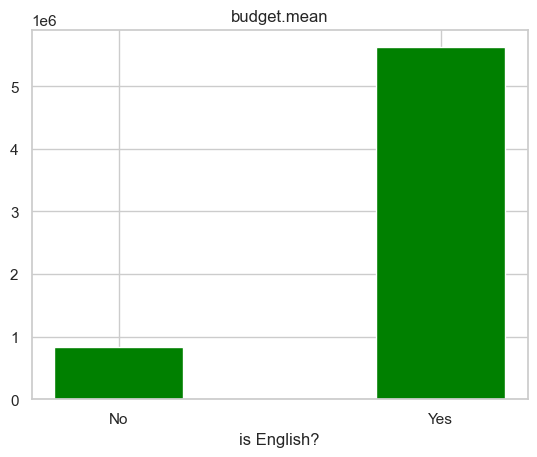

In [45]:
X=['No','Yes']
##Y=[840142,5623334]  
Y=[8.401420e+05	,5.623334e+06]
fig = plt.figure()
plt.bar(X,Y,0.4,color="green")
plt.xlabel("is English?")
plt.title("budget.mean")
plt.show() 

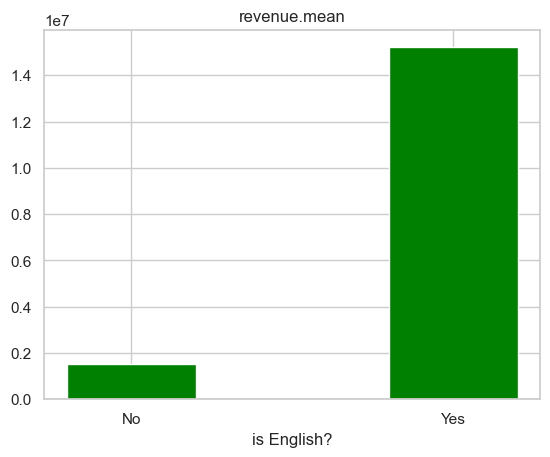

In [46]:
X=['No','Yes']
##Y=[840142,5623334]  
Y=[1.523008e+06,1.520866e+07]
fig = plt.figure()
plt.bar(X,Y,0.4,color="green")
plt.xlabel("is English?")
plt.title("revenue.mean")
plt.show()

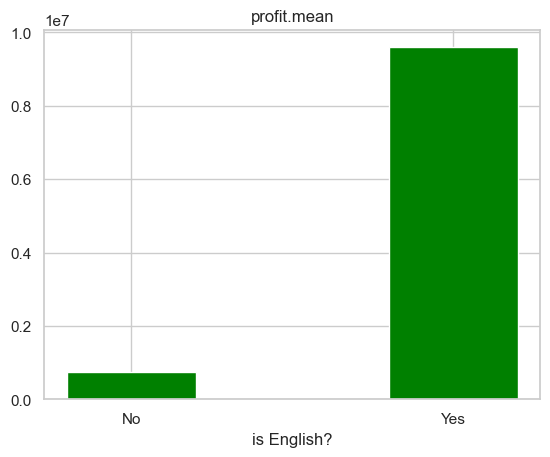

In [47]:
X=['No','Yes']
##Y=[840142,5623334]  
Y=[7.416062e+05,9.597381e+06]
fig = plt.figure()
plt.bar(X,Y,0.4,color="green")
plt.xlabel("is English?")
plt.title("profit.mean")
plt.show()

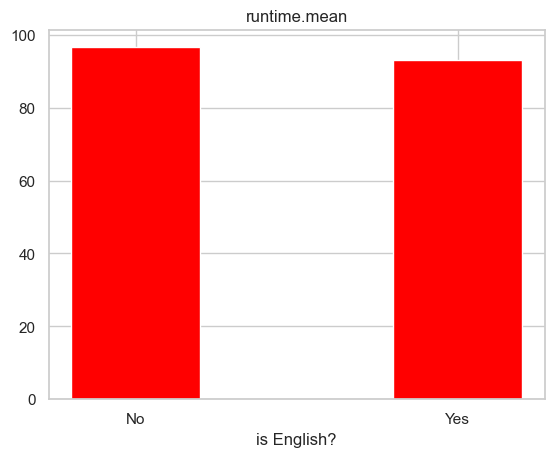

In [48]:
X=['No','Yes']
##Y=[840142,5623334]  
Y=[96.584122,93.199062]
fig = plt.figure()
plt.bar(X,Y,0.4,color="red")
plt.xlabel("is English?")
plt.title("runtime.mean")
plt.show()

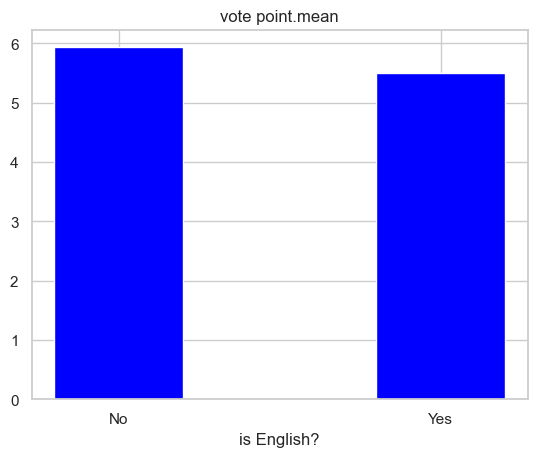

In [49]:
X=['No','Yes']
##Y=[840142,5623334]  
Y=[5.936584,5.497055]
fig = plt.figure()
plt.bar(X,Y,0.4,color="blue")
plt.xlabel("is English?")
plt.title("vote point.mean")
plt.show()

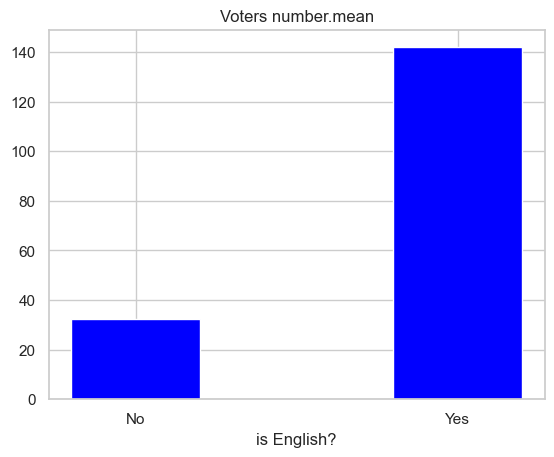

In [50]:
X=['No','Yes']
##Y=[840142,5623334]  
Y=[32.508671,141.888378]
fig = plt.figure()
plt.bar(X,Y,0.4,color="blue")
plt.xlabel("is English?")
plt.title("Voters number.mean")
plt.show()

In [51]:
movies_meta['isen'] = ""
movies_meta.loc[movies_meta['original_language']=='en',"isen"] = "Yes"
movies_meta.loc[movies_meta['original_language']!='en',"isen"] = "No"
movies_meta
dddd = movies_meta['genres'].groupby(movies_meta['isen']).value_counts()
dddd
dddd = pd.DataFrame(dddd)
column = dddd.columns.to_list()
column[0]='count'
dddd.columns = column
dddd.reset_index(drop = False, inplace = True)
d1 = dddd.iloc[0:20]
d2 = dddd.iloc[20:40]
dddd

,isen,genres,count
0,No,Drama,7016
1,No,Comedy,3865
2,No,Romance,1911
3,No,Action,1864
4,No,Thriller,1632
5,No,Crime,1149
6,No,Foreign,932
7,No,Horror,880
8,No,Adventure,816
9,No,Fantasy,721


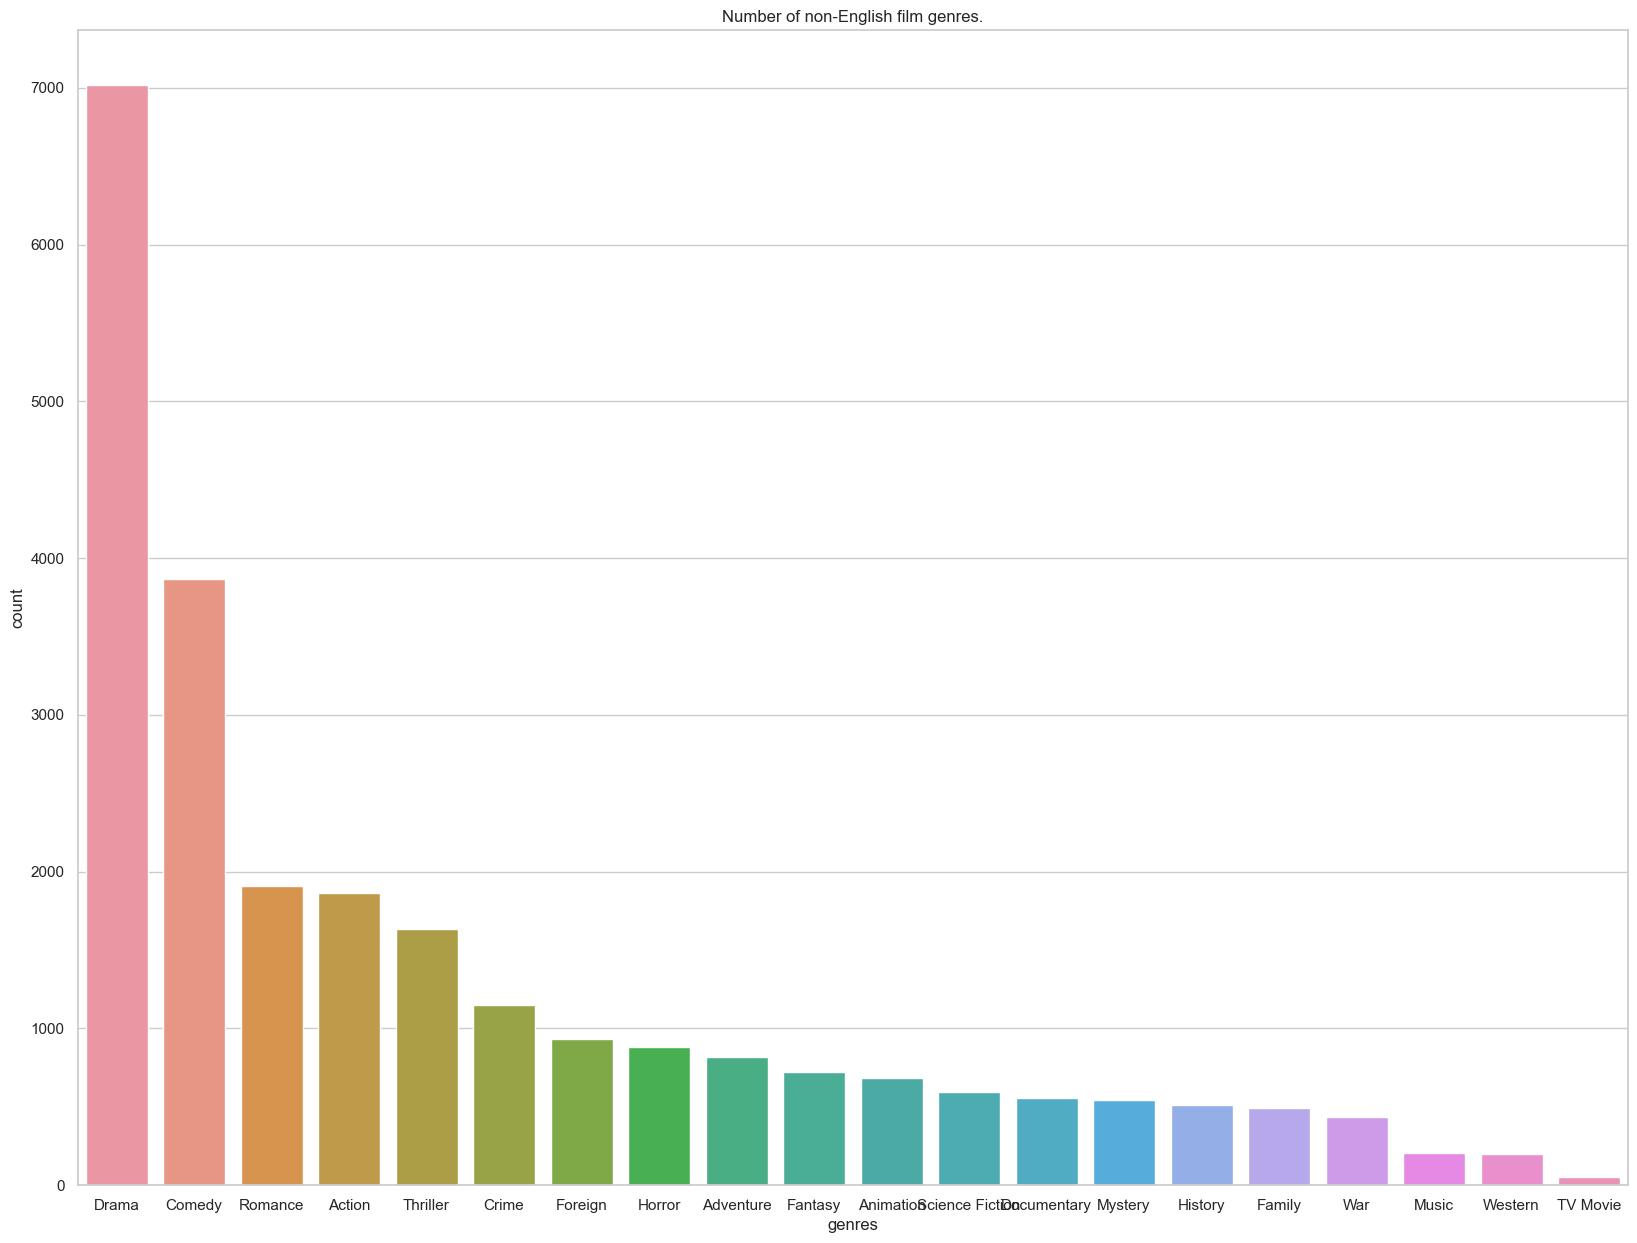

In [52]:
plt.figure(figsize=(20, 15))
sns.set_theme(style="whitegrid")
sns.barplot(x="genres", y="count", data=d1)
plt.title("Number of non-English film genres.")
plt.show()

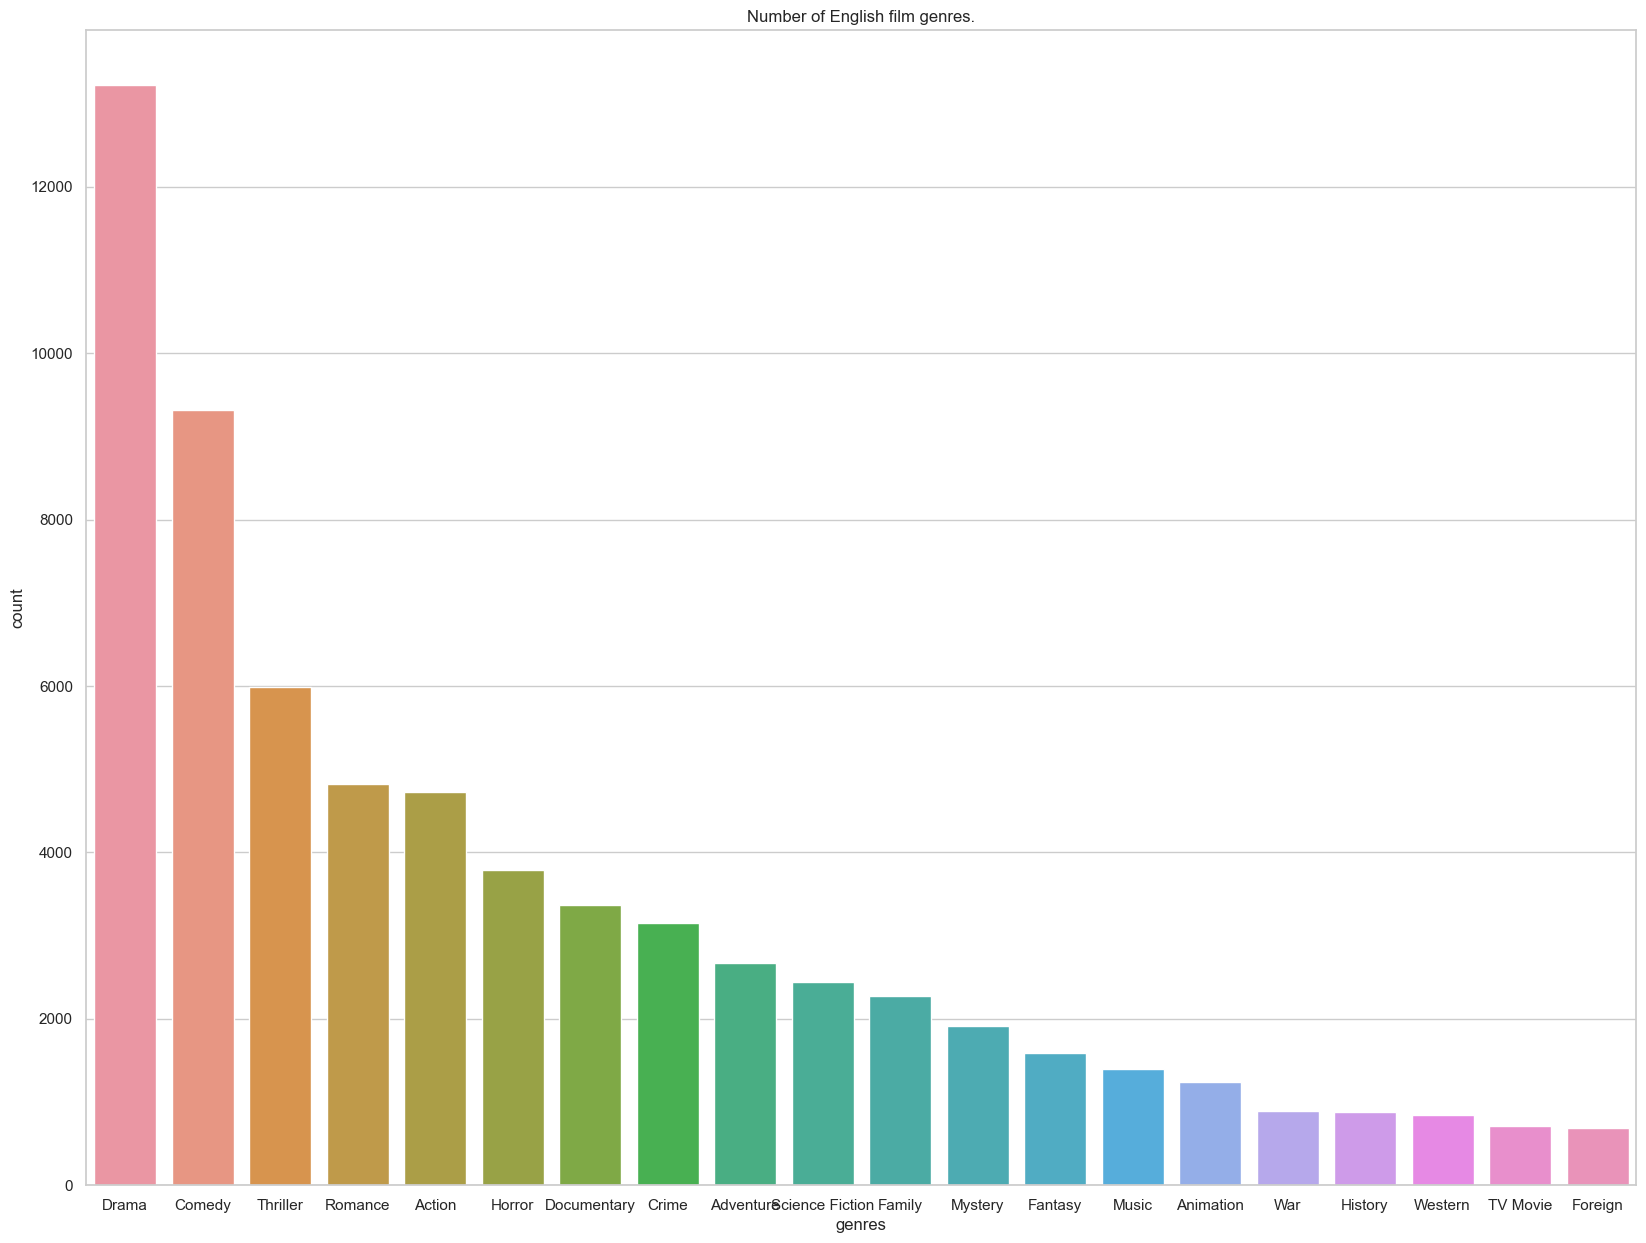

In [53]:
plt.figure(figsize=(20, 15))
sns.set_theme(style="whitegrid")
sns.barplot(x="genres", y="count", data=d2)
plt.title("Number of English film genres.")
plt.show()

In [54]:
movies_meta_unstack['adult'].groupby(movies_meta_unstack['isen']).value_counts()

isen  adult
No    False    13148
      True         4
Yes   False    32195
      True         4
Name: adult, dtype: int64

In [55]:
movies_meta_unstack['month'].groupby(movies_meta_unstack['isen']).value_counts().sort_values()

isen  month
No    07        631
      06        787
      04        926
      05        929
      08        986
      02       1008
      03       1041
      11       1082
      12       1191
      10       1338
      09       1494
      01       1739
Yes   07       2009
      02       2018
      06       2364
      05       2408
      08       2408
      03       2512
      04       2527
      11       2579
      12       2592
      10       3273
      09       3340
      01       4169
Name: month, dtype: int64

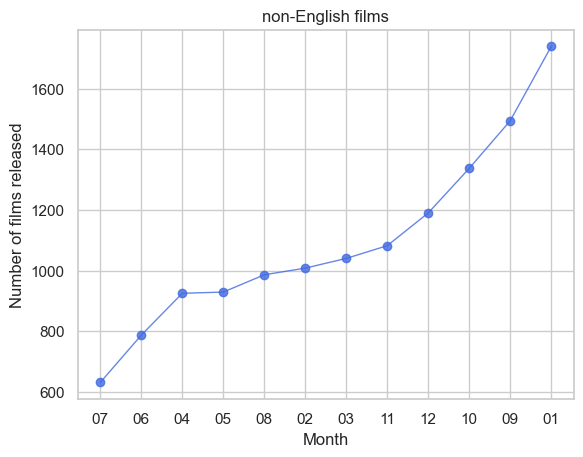

In [56]:
X=['07','06','04','05','08','02','03','11','12','10','09','01']
Y=[631,787,925,929,986,1008,1040,1082,1190,1337,1494,1739]  
fig = plt.figure()
plt.plot(X, Y, 'ro-', color='#4169E1', alpha=0.8, linewidth=1, label='一些数字')
plt.xlabel("Month")
plt.ylabel("Number of films released")
plt.title("non-English films")
plt.show() 

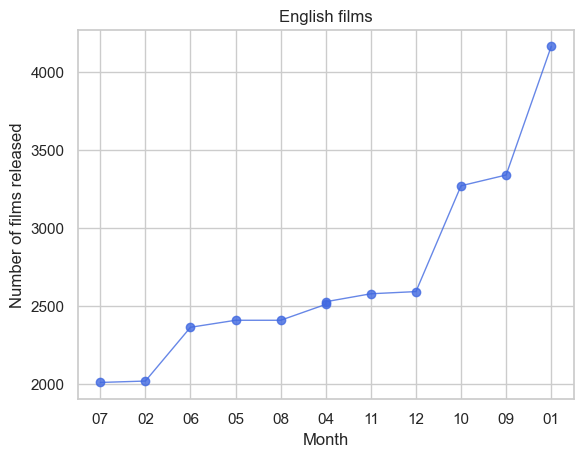

In [57]:
X=['07','02','06','05','08','04','04','11','12','10','09','01']
Y=[2009,2018,2363,2408,2408,2510,2527,2578,2592,3271,3340,4165]  
fig = plt.figure()
plt.plot(X, Y, 'ro-', color='#4169E1', alpha=0.8, linewidth=1)
plt.xlabel("Month")
plt.ylabel("Number of films released")
plt.title("English films")
plt.show() 

In [58]:
movies_meta_unstack['year'].groupby(movies_meta_unstack['isen']).value_counts().sort_values(ascending=False)

isen  year
Yes   2014    1385
      2013    1318
      2015    1277
      2012    1200
      2011    1132
              ... 
No    1874       1
      1887       1
      1892       1
      1893       1
Yes   2020       1
Name: year, Length: 261, dtype: int64

<AxesSubplot: title={'center': 'Number of Movies Released each Month'}, xlabel='release_month'>

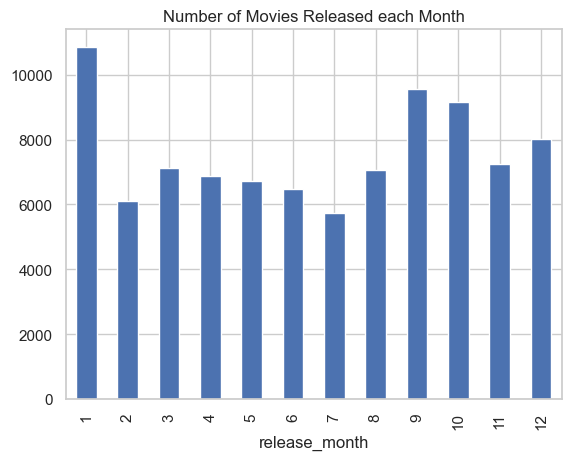

In [59]:
# Number of Movies Released each Month
movies_meta['release_date'] = pd.to_datetime(movies_meta['release_date'], format ='%Y-%m-%d')
movies_meta['release_month']=pd.DatetimeIndex(movies_meta['release_date']).month
# In which month of the year will the most films be released?
month_stat = movies_meta.groupby("release_month").size()
month_stat.plot(y = "number",kind = "bar",title= "Number of Movies Released each Month")

array([<AxesSubplot: title={'center': 'budget'}, xlabel='release_month'>,
       <AxesSubplot: title={'center': 'revenue'}, xlabel='release_month'>,
       <AxesSubplot: title={'center': 'vote_average'}, xlabel='release_month'>],
      dtype=object)

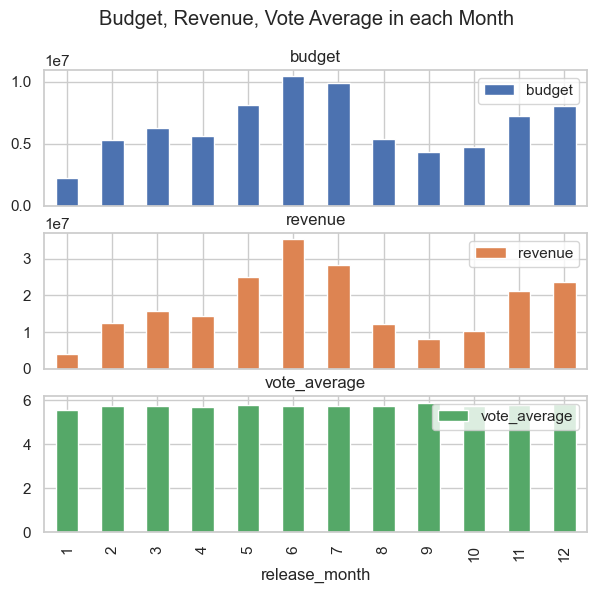

In [60]:
movies_meta['budget']= movies_meta['budget'].apply(pd.to_numeric)
# changes in budget
# changes in revenue
# changes in vote average
month_avg = movies_meta.groupby("release_month").agg({'budget':'mean','revenue':'mean','vote_average':'mean'})
month_avg
month_avg.plot(subplots = True,kind = "bar",figsize=(7,6),title = "Budget, Revenue, Vote Average in each Month")